## Phone

In [40]:
pd.merge(full_df.reset_index()[['call_id', 'sent_score', 'transcript']], pd.read_excel('data/phone_survey.xlsx', skiprows = 3), 
         left_on = 'call_id', right_on = 'ConnID', how = 'inner').to_csv('220809_transcript_survey_merge.csv', index = False)

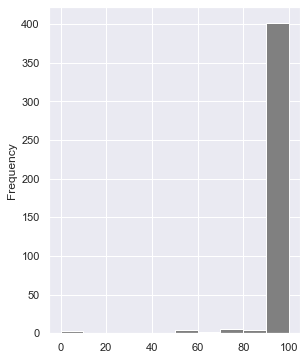

In [92]:
plt.figure(figsize = [4.5, 6])
pd.read_excel('data/phone_survey.xlsx', skiprows = 3)['GSK Score'].plot(kind = 'hist', xlabel = 'GSK Score', color = 'grey')
plt.show()

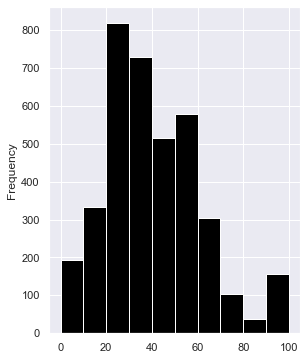

In [89]:
plt.figure(figsize = [4.5, 6])
((full_df['sent_score'] + 1) * 50).plot(kind = 'hist', color = 'black')
plt.show()

## 1. Sentiment (via [Colab](https://colab.research.google.com/drive/16u6I9A3jVERjupHUhnX5NMlq1EK08hdm#scrollTo=rg0Mlwsxuojv))

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Options
sns.set()
pd.set_option('display.max_columns', None)

# Import `full_df`
full_df = pd.read_csv('df/full_df.csv', index_col = 'call_id', dtype = str, parse_dates = ['CREATED_DATE_TIME'])
# Convert vars
full_df['call_len_sec'] = full_df['call_len_sec'].astype(int)
full_df['date'] = full_df['CREATED_DATE_TIME'].dt.date
full_df['call_len_min'] = full_df['call_len_sec'] / 60
full_df['weekday'] = full_df['CREATED_DATE_TIME'].dt.weekday
full_df['hour'] = full_df['CREATED_DATE_TIME'].dt.hour
# Make vars
full_df['call_len_quartile'] = pd.qcut(full_df['call_len_min'], 4, ['<4 min', '4-6.5 min', '6.5-11.5 min', '>11.5 min'])
# Rename
full_df.loc[full_df['Call content'] == 'Typical', 'Call content'] = 'Normal'
# Merge sentiment
full_df = full_df.join(pd.read_csv('df/220809_sentiment_cus.csv').set_index('call_id'))
full_df = full_df.rename(columns = {'conf': 'sent_conf'})
# Get sentiment
def calculate_sentiment(sent_score):
    if not np.isnan(sent_score):
        if sent_score < 1/3:
            return 'Negative'
        elif sent_score < 2/3:
            return 'Mixed'
        else:
            return 'Positive'
    else:
        return np.nan
full_df['sent_score'] = full_df['pos'] / full_df['n_chunks']
full_df['sent_cat'] = full_df['sent_score'].apply(calculate_sentiment)
full_df['sent_score'] = (full_df['sent_score'] - 0.5) * 2 # Reframe from -1 to 1
# Add brand and BU (https://docs.google.com/spreadsheets/d/1WGaJIlCNnznzrWvFYWoIcuIUEaME0EN7wJ8d1_plixo)
BU_map = pd.read_csv('df/BU_map.csv')
brand_dict = dict(zip(BU_map['PRODUCT_NAME'], BU_map['product_group']))
full_df['brand'] = full_df['PRODUCT_NAME'].apply(lambda x: brand_dict[x] if isinstance(x, str) else np.nan)
BU_dict = dict(zip(BU_map['product_group'], BU_map['BU']))
full_df['BU'] = full_df['brand'].apply(lambda x: BU_dict[x] if isinstance(x, str) else np.nan)
# Export
full_df.drop(columns = ['pos', 'neg', 'n_chunks']).to_csv('df/full_df_sentiment.csv')

# Drop
print(f"dropped calls: {((full_df[['drop_testing_training', 'drop_call_len_0', 'drop_voicemail']] == 'True').sum(axis = 1) != 0).sum()}")
print(f"dropped calls len: {full_df[((full_df[['drop_testing_training', 'drop_call_len_0', 'drop_voicemail']] == 'True').sum(axis = 1) != 0)]['call_len_min'].sum()}")
full_df = full_df[((full_df[['drop_testing_training', 'drop_call_len_0', 'drop_voicemail']] == 'True').sum(axis = 1) == 0)]

dropped calls: 272
dropped calls len: 318.5


### Call length

In [2]:
pd.crosstab(full_df['Call length'], full_df['Call content'], full_df['call_len_sec'], aggfunc = sum, normalize = True) * 100

Call content,Atypical,Normal
Call length,,
Long,54.248949,23.526110
Short,9.063562,13.161379


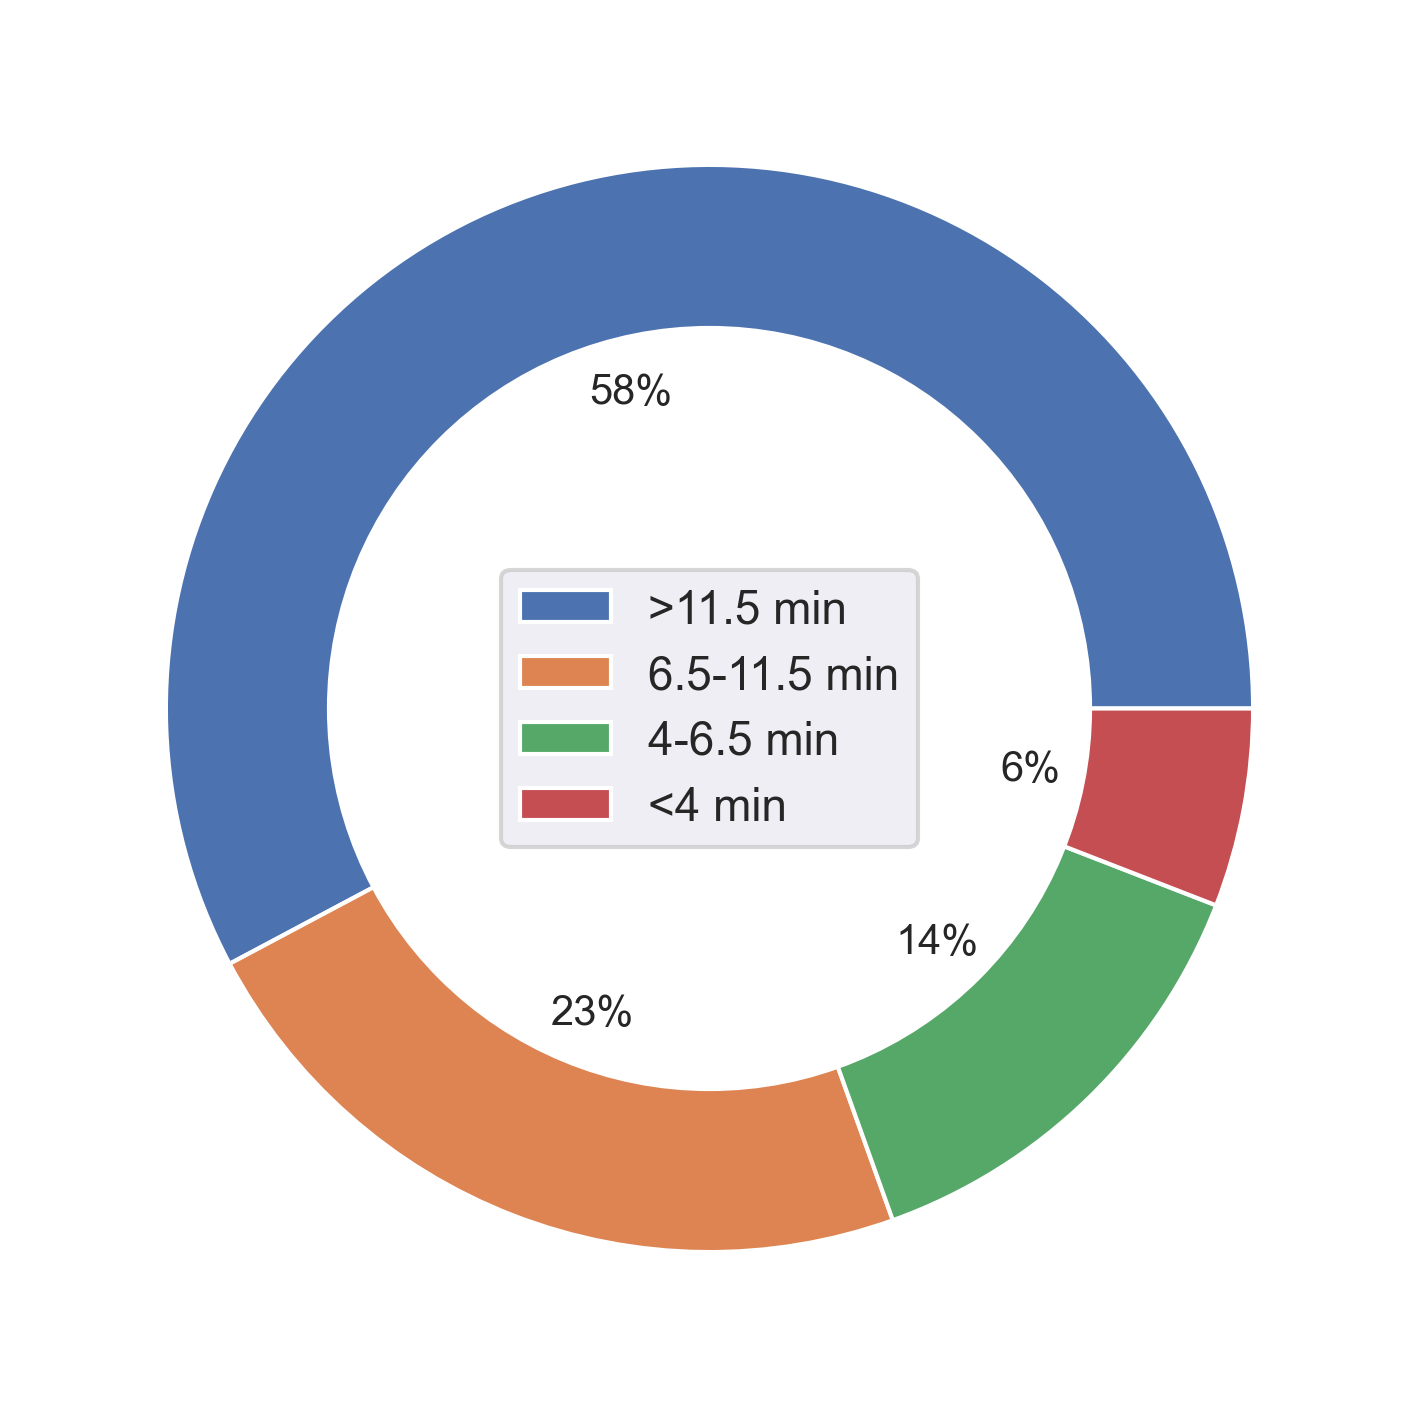

In [3]:
cl_gb = full_df.groupby('call_len_quartile')['call_len_min'].sum().sort_values(ascending = False)
plt.figure(figsize = [6, 6], dpi = 300)
plt.pie(cl_gb, autopct = lambda x: f'{x:.0f}%')
p=plt.gcf()
p.gca().add_artist(plt.Circle((0,0), 0.7, color='white'))
plt.legend(cl_gb.index, loc = 'center')
plt.show()

In [4]:
full_df.groupby(['call_len_quartile'])['IVR_REASON'].value_counts().groupby(level = 0).head(5).to_frame()

IVR_REASON
call_len_quartile IVR_REASON                                    
<4 min            Patient Other Options                      107
                  GSK Source                                  88
                  Back Off Menu Zero Out                      80
                  Role Menu Max Errors                        53
                  Nucala Inbound Call                         48
4-6.5 min         GSK Source                                 113
                  Patient Other Options                      105
                  Nucala Inbound Call                         51
                  PAP Agent Request                           49
                  Coupon Max Errors                           48
6.5-11.5 min      GSK Source                                 100
                  Patient Other Options                       93
                  Patient Other Med Qs                        74
                  Nucala Inbound Call                         57
                  Quality Complaint                           52
>11.5 min         Quality Complaint                          135
                  Patient Other Med Qs                       107
                  Benlysta Promotional LASH Transfer          76
                  Patient Other Options                       73
                  GSK Source                                  63

In [5]:
full_df.groupby(['Call content', 'Call length'])['IVR_REASON'].value_counts().groupby(level = [0, 1]).head(5).to_frame()

IVR_REASON
Call content Call length IVR_REASON                                    
Atypical     Long        Quality Complaint                          110
                         Patient Other Med Qs                        97
                         Benlysta Promotional LASH Transfer          81
                         Patient Other Options                       75
                         GSK Source                                  68
             Short       Patient Other Options                       96
                         GSK Source                                  84
                         Nucala Inbound Call                         42
                         Nurse Other Options                         42
                         Patient Other Med Qs                        34
Normal       Long        GSK Source                                  80
                         Patient Other Med Qs                        79
                         Quality Complaint                           71
                         Patient Other Options                       65
                         Nucala Inbound Call                         47
             Short       Patient Other Options                      134
                         GSK Source                                 122
                         Back Off Menu Zero Out                      72
                         Nucala Inbound Call                         63
                         Role Menu Max Errors                        57

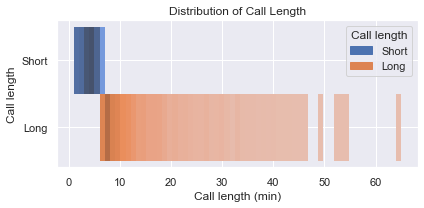

In [6]:
plt.figure(figsize = [6, 3])
ax = sns.histplot(data = full_df, x = 'call_len_min', y = 'Call length', hue = 'Call length')
ax.set(title = 'Distribution of Call Length', xlabel = 'Call length (min)')
plt.tight_layout()

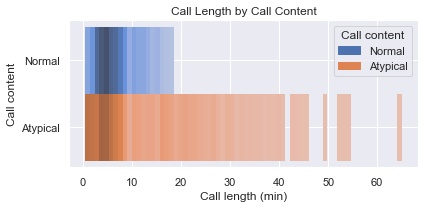

In [7]:
plt.figure(figsize = [6, 3])
ax = sns.histplot(data = full_df.sort_values('Call content', ascending = False), x = 'call_len_min', y = 'Call content', hue = 'Call content')
ax.set(title = 'Call Length by Call Content', xlabel = 'Call length (min)')
plt.tight_layout()

### Overall sentiment

/Users/tejomay.gadgil/miniforge3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tejomay.gadgil/miniforge3/lib/python3.9/site-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))


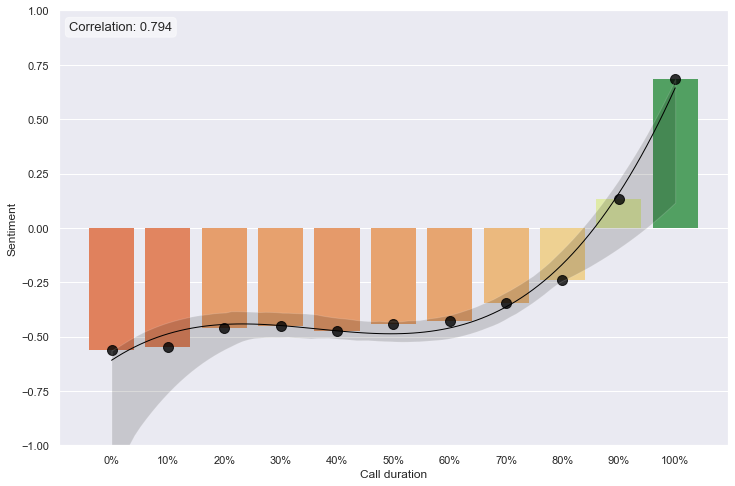

In [443]:
bins = 11
order = 1
if bins > 5: order = 3
import ast
sraw = pd.read_csv('df/220809_sentiment_raw_cus.csv').set_index('call_id').rename(columns = {'transcript_cus': 't_chunks'})
sraw['t_chunks'] = sraw['t_chunks'].apply(ast.literal_eval).apply(lambda x: [y[0] for y in x]).apply(lambda x: [y['label'] for y in x]) # Don't ask
# Make plotting df
call_sent = pd.DataFrame(zip(*sraw['t_chunks'].apply(lambda x: [(np.nanmean(q == 'POSITIVE') - 0.5) * 2 for q in np.array_split(x, bins)]))).T
call_sent = call_sent[(call_sent.isna().sum(axis = 1) == 0)].copy() # Drop np.nan
call_sent = pd.DataFrame({'avg_sent': call_sent.mean(), 'quart': range(0, bins)})

# Plot
plt.figure(figsize = (12, 8))
ax = sns.barplot(data = call_sent, x = 'quart', y = 'avg_sent', 
                 palette = list(((call_sent['avg_sent'] + 1) / 2).apply(plt.cm.RdYlGn)), linewidth = 0, dodge = False)
ax = sns.regplot(data = call_sent, x = 'quart', y = 'avg_sent', order = order, marker = 'o', color = 'black',
                scatter_kws = {'s' : 100}, line_kws={'linewidth' : 1})
ax.set(ylim = (-1, 1), xlabel = 'Call duration', ylabel = 'Sentiment')
ax.set_xticks([i for i in range(11)], [f'{i}%' for i in range(0, 110, 10)])
bbox = dict(boxstyle = 'round', facecolor = 'white', alpha = 0.5)
plt.text(-0.75, 0.95, f'Correlation: {call_sent.corr().iloc[0, 1].round(3)}', 
         fontsize = 13, linespacing = 1.5, verticalalignment='top', bbox = bbox)
plt.show()

In [11]:
full_df[['call_len_sec', 'sent_score']].corr()

,call_len_sec,sent_score
call_len_sec,1.000000,-0.197126
sent_score,-0.197126,1.000000


In [8]:
pd.crosstab(full_df['Call content'], full_df['Call length'], full_df['sent_score'], aggfunc = 'mean')

Call length,Long,Short
Call content,,
Atypical,-0.318011,-0.168308
Normal,-0.269100,-0.155450


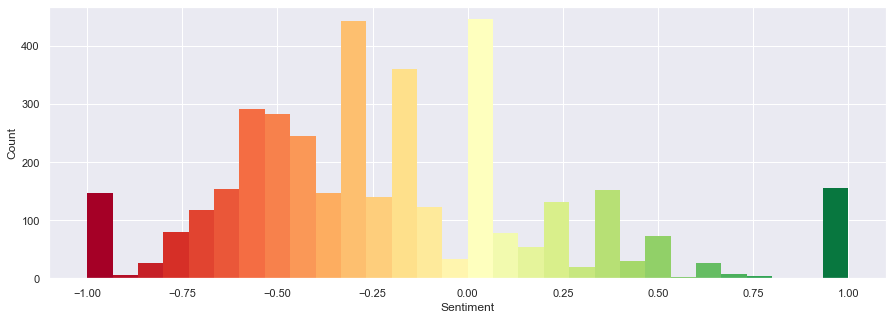

In [9]:
nbins = 30
plt.figure(figsize = [15, 5])
n, bins, patches = plt.hist(full_df['sent_score'], nbins, linewidth = 0)
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', plt.cm.RdYlGn(i / nbins))
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

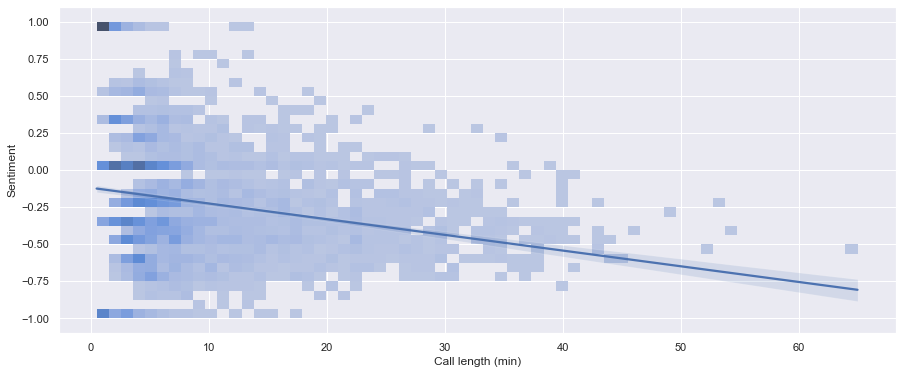

In [10]:
nbins = 30
plt.figure(figsize = [15, 6])
sns.histplot(data = full_df, x = 'call_len_min', y = 'sent_score', legend = False)
sns.regplot(data = full_df, x = 'call_len_min', y = 'sent_score', scatter = False)
plt.xlabel('Call length (min)')
plt.ylabel('Sentiment')
plt.show()

### Brand

In [13]:
BU_colmap = {'RBU': sns.color_palette()[3], 'SBU': sns.color_palette()[1], 'VBU': sns.color_palette()[2], 'OBU': sns.color_palette()[0]}
brand_df = full_df[~(full_df['BU'].isna())]

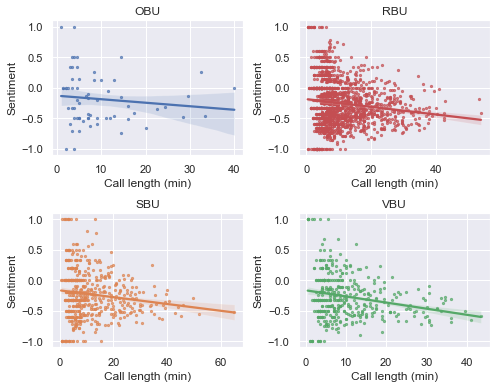

In [14]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (7, 5.5))
i = 0
for _BU, _df in brand_df.groupby(['BU']):
    _ax = ax[i // 2, i % 2]
    # sns.histplot(ax = _ax, data = _df, x = 'call_len_min', y = 'sent_score', 
    #                 color = BU_colmap[_BU])
    # sns.regplot(ax = _ax, data = _df, x = 'call_len_min', y = 'sent_score', 
    #                 color = BU_colmap[_BU], scatter = False)
    sns.regplot(ax = _ax, data = _df, x = 'call_len_min', y = 'sent_score', 
                    color = BU_colmap[_BU], scatter_kws = {'s': 5, 'alpha': 0.7})
    _ax.set_title(_BU)
    _ax.set(xlabel = 'Call length (min)', ylabel = 'Sentiment')
    i+=1
plt.tight_layout()

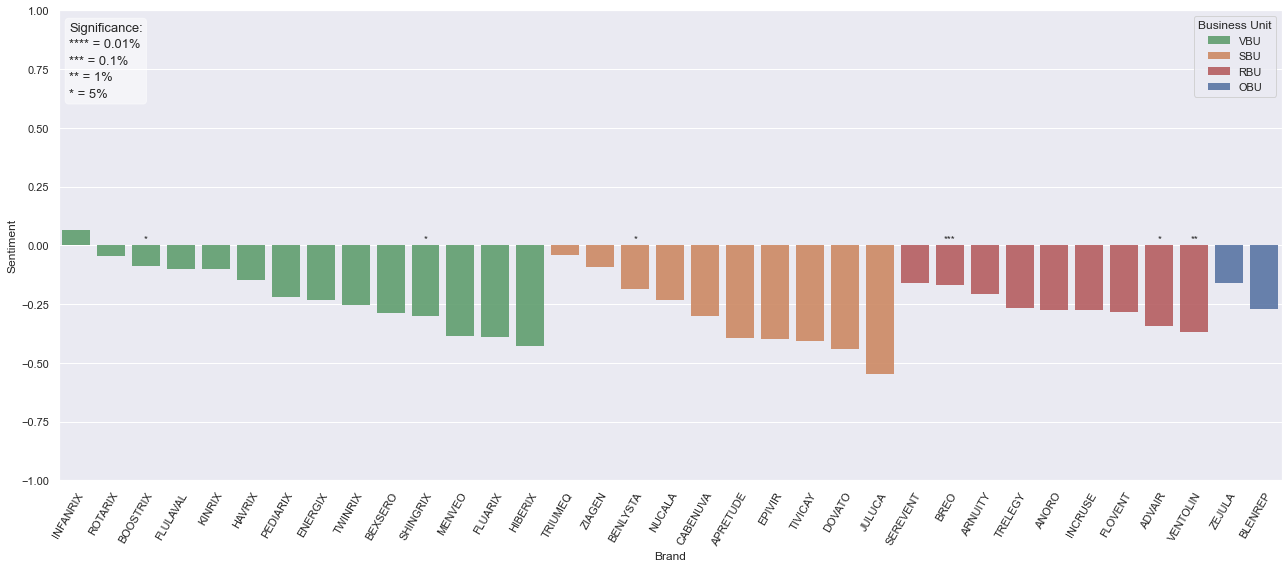

In [25]:
# Get significance
brand_pval_dict = {}
for _brand, _brand_df in brand_df.groupby(['brand']):
    _pval = ttest_ind(brand_df['sent_score'], # Global sample
                      _brand_df['sent_score'], # Brand sample
                      nan_policy = 'omit').pvalue
    if _pval <= 1e-4:
        _ast = "****"
    elif _pval <= 1e-3:
        _ast = "***"
    elif _pval <= 1e-2:
        _ast = "**"
    elif _pval <= 5e-2:
        _ast = "*"
    else:
        _ast = ''
    brand_pval_dict[_brand] = _ast
plt.figure(figsize = (18, 8))
# Make df
data = brand_df.groupby(['BU', 'brand'])['sent_score'].mean().reset_index().sort_values(['BU', 'sent_score'], ascending = False)
data['sig'] = data['brand'].apply(lambda x: brand_pval_dict[x])
# Plot
ax = sns.barplot(data = data, x = 'brand', y = 'sent_score', hue = 'BU', palette = BU_colmap, linewidth = 0, dodge = False, alpha = 0.9) 
ax.set_xticklabels(ax.get_xticklabels(), rotation = 60, ha="right", rotation_mode="anchor");
ax.set(ylim = (-1, 1), xlabel = 'Brand', ylabel = 'Sentiment')
# Significance legend
plt.legend(loc = 'upper right', title = 'Business Unit')
for i, sig in enumerate(data['sig']):
    plt.text(i, 0.03, sig, ha='center', va='center')
bbox = dict(boxstyle = 'round', facecolor = 'white', alpha = 0.5)
plt.text(-0.2, 0.95, 'Significance:\n**** = 0.01%\n*** = 0.1%\n** = 1%\n* = 5%', 
         fontsize = 13, linespacing = 1.5, verticalalignment='top', bbox = bbox)
plt.tight_layout()

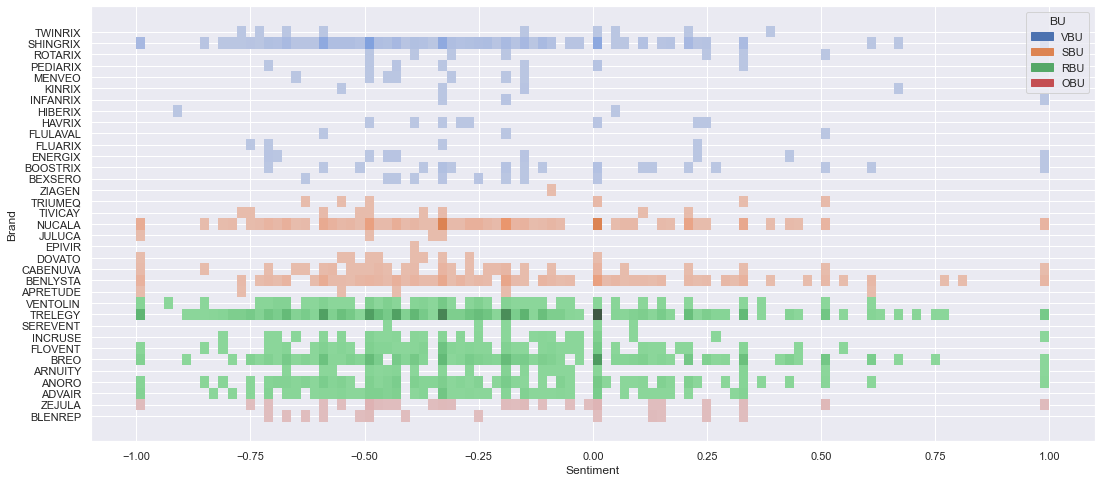

In [24]:
plt.figure(figsize = (18, 8))
ax = sns.histplot(data = brand_df.sort_values(['BU', 'brand'], ascending = False), x = 'sent_score', y = 'brand', hue = 'BU', bins = 100)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Brand')
plt.show()

### Matt corr

In [769]:
t = full_df.groupby('date').apply(lambda x: {'average handling time': (x['call_len_sec'].sum() / x.shape[1]), 'average sentiment': x['sent_score'].mean()}).apply(pd.Series) 
np.corrcoef(t['average handling time'], t['average sentiment'])

array([[ 1.        , -0.08624551],
       [-0.08624551,  1.        ]])

In [770]:
pd.DataFrame({'tod_sin': full_df['CREATED_DATE_TIME'].dt.hour, 'sent': full_df['sent_score']}).corr()

,tod_sin,sent
tod_sin,1.000000,-0.018264
sent,-0.018264,1.000000


### Customer

In [29]:
cus_df = full_df[~(full_df['CONTACT_TYPE'] == 'US Internal Contact')]

In [33]:
# Mean and significance
for _cus, _cus_df in cus_df.groupby(['CONTACT_TYPE']):    
    _pval = ttest_ind(cus_df['sent_score'], # Global sample
                      _cus_df['sent_score'], # Brand sample
                      nan_policy = 'omit').pvalue
    print(_cus, _cus_df['sent_score'].mean().round(3), '{:0.1e}'.format(_pval))

Patient -0.104 8.2e-11
US Consumer -0.272 5.0e-07
US Professional -0.209 7.4e-01


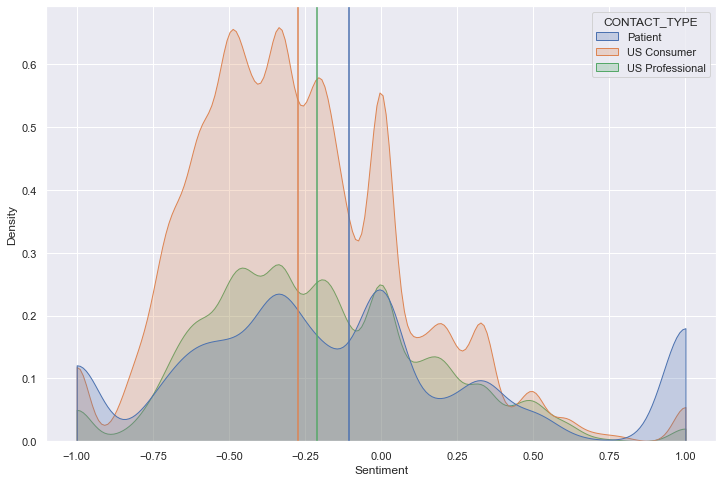

In [35]:
plt.figure(figsize = (12, 8))
ax = sns.kdeplot(data = cus_df.sort_values(['CONTACT_TYPE']), x = 'sent_score', 
                 hue = 'CONTACT_TYPE', fill = 'CONTACT_TYPE', bw_adjust = 0.5, clip = [-1, 1])
ax.set(xlabel = 'Sentiment')
# Add mean line
for i, mean in enumerate(cus_df.groupby(['CONTACT_TYPE'])['sent_score'].mean()):
    plt.axvline(x = mean, color = sns.color_palette(n_colors = 3)[i])

plt.show()

<AxesSubplot:title={'center':'Sentiment by customer'}, xlabel='Date', ylabel='Sentiment'>

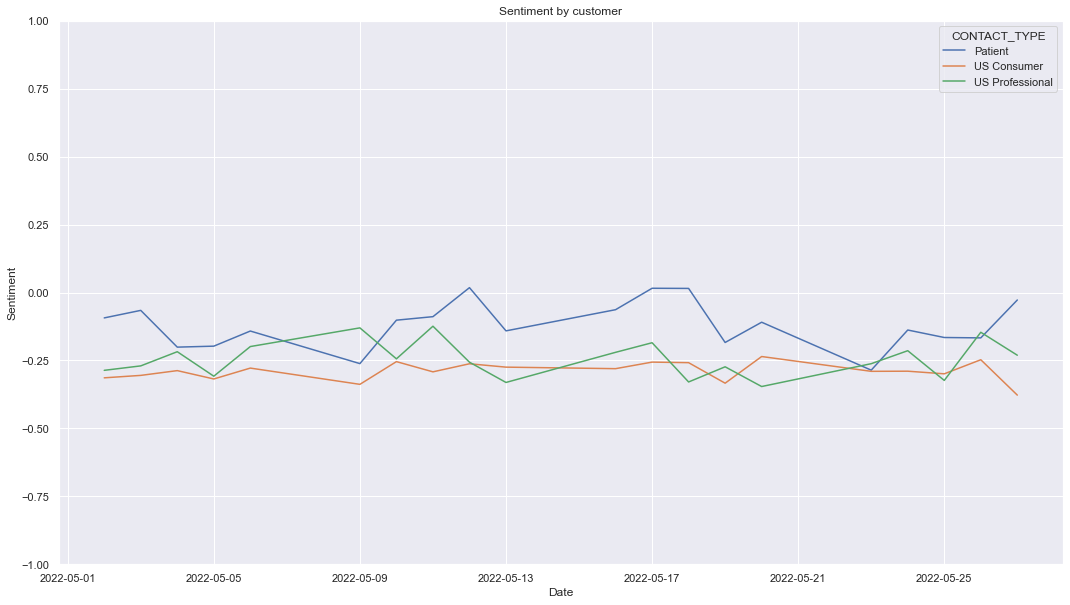

In [45]:
cus_df.groupby(['CONTACT_TYPE', 'date'])['sent_score'].mean().reset_index().pivot(index = 'date', columns = 'CONTACT_TYPE', values = 'sent_score') \
       .plot(figsize = (18, 10), title = 'Sentiment by customer', ylabel = 'Sentiment', xlabel = 'Date', ylim = [-1, 1])

## 2. Topic (`gensim`)

In [ ]:
# # nltk.download('punkt')
# # nltk.download('wordnet')
# # nltk.download('omw-1.4')
# # nltk.download('vader_lexicon')

In [78]:
import nltk
import gensim
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    '''
    Preprocess a string. (https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d)
    :parameter
        :param text: string - name of column containing text
        :param lst_stopwords: list - list of stopwords to remove
        :param flg_stemm: bool - whether stemming is to be applied
        :param flg_lemm: bool - whether lemmitisation is to be applied
    :return
        cleaned text
    '''
    import re
    text = str(text)
    # drop redacted
    text = re.sub('\[\#\#redacted\#\#\]|\[\w*SDI_\w*\]', '', text)
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', text.lower().strip())
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]            
    ## back to string from list
    text = " ".join(lst_text)
    return text

top_df = full_df[(~full_df['SUBJECT'].isna()) & (~(full_df['transfer'] == 'True'))]

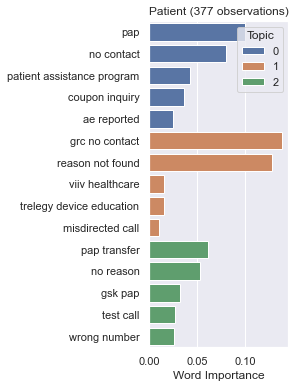

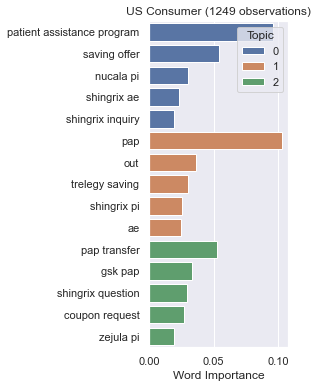

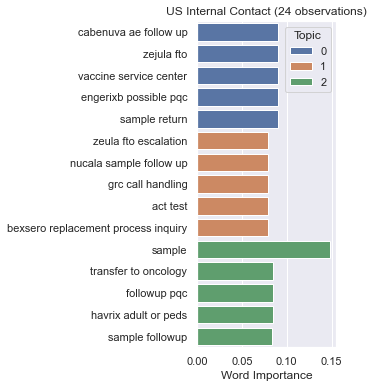

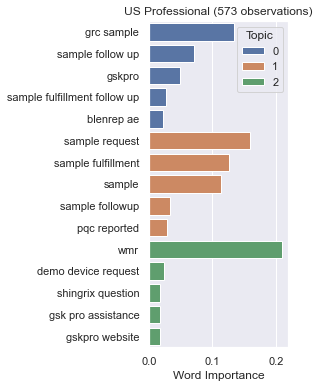

In [80]:
n_gram = 4
num_topics = 3
for _g, _df in top_df.groupby('CONTACT_TYPE'):
    corpus = _df['SUBJECT'].apply(utils_preprocess_text)
    # corpus = full_df['SUBJECT'][(~full_df['SUBJECT'].isna() & ~(full_df['transfer'] == True))].apply(utils_preprocess_text)
    ## pre-process corpus
    lst_corpus = []
    for string in corpus:
        lst_words = string.split()
        lst_grams = [" ".join(lst_words[i:i + n_gram]) for i in range(0, len(lst_words), n_gram)]
        lst_corpus.append(lst_grams)## map words to an id
    id2word = gensim.corpora.Dictionary(lst_corpus) ## dict {word: freq}
    dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] ## train LDA
    lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=num_topics, 
                                                random_state=123, update_every=1, chunksize=100, passes=10, 
                                                alpha='auto', per_word_topics=True)   
    ## output
    lst_dics = []
    for i in range(0,num_topics):
        lst_tuples = lda_model.get_topic_terms(i)
        for tupla in lst_tuples:
            lst_dics.append({"topic":i, "id":tupla[0], 
                             "word":id2word[tupla[0]], 
                             "weight":tupla[1]})
    dtf_topics = pd.DataFrame(lst_dics, 
                             columns=['topic','id','word','weight'])
    dtf_topics = dtf_topics.sort_values(['topic', 'weight'], ascending = [True, False]).groupby('topic').head(5)
    ## plot
    fig, ax = plt.subplots(figsize = [2.5, 6])
    sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title(label = f"{_g} ({_df.shape[0]} observations)")
    ax.set(ylabel="", xlabel="Word Importance")
    plt.legend(loc='upper right', title = 'Topic')
    plt.show()